In [97]:
import os
import mlflow

mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
from mlflow.models import infer_signature

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('future.no_silent_downcasting', True)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MaxAbsScaler
from mlflow import log_metric, log_param, log_artifacts

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
import itertools

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input director

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [98]:
data = pd.read_csv("data/2024-06-05_18-44-19_unscaled_allFeature.csv", sep="\t")
print("Number of datapoints:", len(data))
data.head()
datasetname = '2024-06-05_18-44-19_unscaled_allFeature.csv'

Number of datapoints: 2208


In [99]:
#Scaling
max_abs_scaler = MaxAbsScaler()
data_maxabs = max_abs_scaler.fit_transform(data)

# Building the Model
* KMeans
* DBSCAN

In [100]:
from sklearn.cluster import KMeans

Elbow Method to determine the number of clusters to be formed:


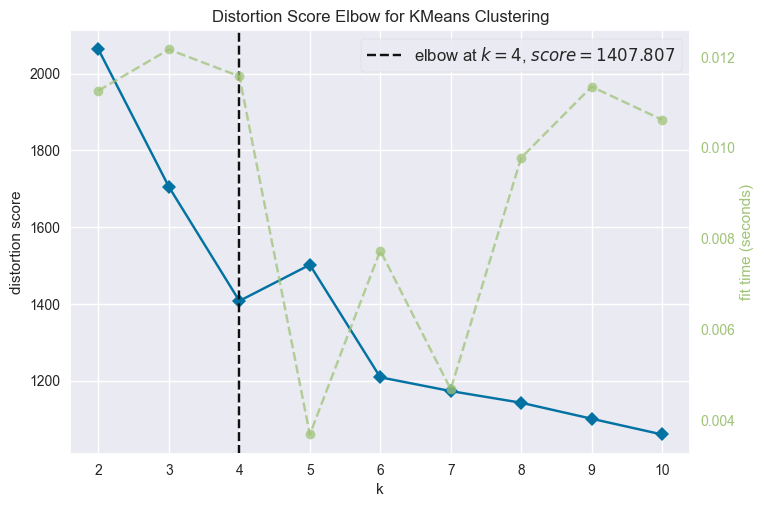

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [101]:
from yellowbrick.cluster import KElbowVisualizer
print('Elbow Method to determine the number of clusters to be formed:')
data_maxabs = data_maxabs[~np.isnan(data_maxabs).any(axis=1), :]
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(data_maxabs)
Elbow_M.show()

In [102]:
def plot_k_distance(data, min_samples):
    neighbors = NearestNeighbors(n_neighbors=min_samples)
    neighbors_fit = neighbors.fit(data)
    distances, indices = neighbors_fit.kneighbors(data)
    distances = np.sort(distances[:, min_samples-1], axis=0)
    plt.plot(distances)
    plt.xlabel('Data Points sorted by distance')
    plt.ylabel(f'{min_samples}-distance')
    plt.show()

In [103]:
def evaluate_k_clustering(data, k):
    X = data
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, labels)
    davies_bouldin_avg = davies_bouldin_score(X, labels)
    return silhouette_avg, davies_bouldin_avg

In [104]:
# Function to log experiment details to MLflow for k means
def log_k_experiment(combination, k, silhouette_avg, davies_bouldin_avg):
    dataset: PandasDataset = mlflow.data.from_pandas(data)
    run_name = f"k_means k={k}_scaled"
    with mlflow.start_run(run_name=run_name, experiment_id='759253670368597458'):
        mlflow
        mlflow.log_input(dataset)
        mlflow.log_param("dataset", datasetname)
        mlflow.log_param("features", combination)
        mlflow.log_param("k", k)
        mlflow.log_metric("silhouette_score", silhouette_avg)
        mlflow.log_metric("davies_bouldin_score", davies_bouldin_avg)
        mlflow.set_tag("algorithm", "KMeans")

In [105]:
# Iterate over all possible feature combinations
#for L in range(1, len(data.columns) + 1):
 #   for combination in itertools.combinations(data.columns, L):
  #      for k in k_range:
   #         silhouette_avg, davies_bouldin_avg = evaluate_clustering(data, combination, k)
    #        log_experiment(combination, k, silhouette_avg, davies_bouldin_avg)
     #       print(f"Logged {combination} with k={k}")

In [106]:
k_range = np.arange(4, 7, 1)

In [107]:
combination = data.columns

for k in k_range:
    silhouette_avg, davies_bouldin_avg = evaluate_k_clustering(data_maxabs, k)
    log_k_experiment(combination, k, silhouette_avg, davies_bouldin_avg)
    print(f"Logged with k={k}")

/Users/felixwissel/miniconda3/lib/python3.12/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/Users/felixwissel/miniconda3/lib/python3.12/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data co

Logged with k=4
Logged with k=5
Logged with k=6


/Users/felixwissel/miniconda3/lib/python3.12/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [108]:
print("Clustering evaluation completed and logged to MLflow.")

Clustering evaluation completed and logged to MLflow.


In [109]:
def plot_cardinality_cluster_kmeans(data, k):
    X = data
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    unique_labels = set(labels)
    if len(unique_labels) > 1:
        n_clusters = len(set(labels)) 
        n_noise = list(labels).count(-1)    
    
    cardinality = [list(labels).count(label) for label in unique_labels]
    clusters = ['Noise' if label == -1 else f'Cluster {label}' for label in unique_labels]
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=clusters, y=cardinality)
    plt.title('Cardinality of Each Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Points')
    plt.show()

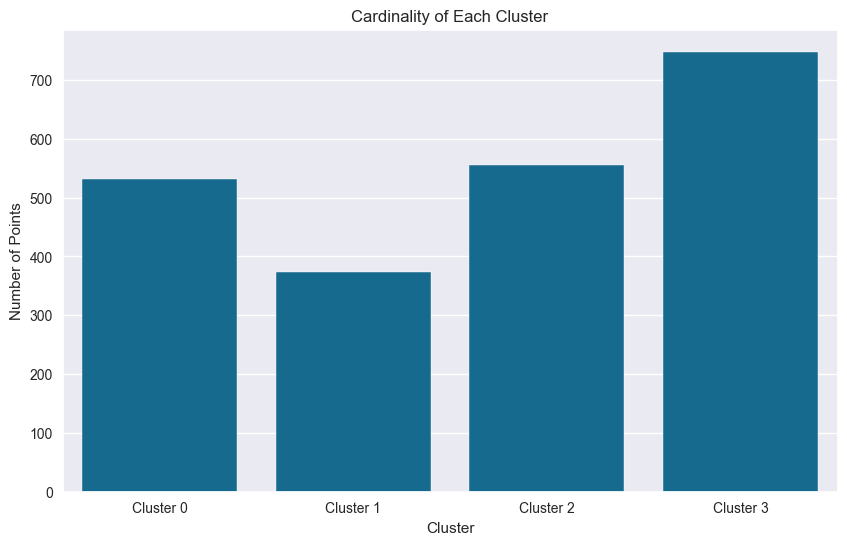

In [110]:
plot_cardinality_cluster_kmeans(data_maxabs, 4)

In [58]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
data['Cluster'] = kmeans.fit_predict(data_maxabs)
clusters = data['Cluster'].unique()

In [59]:
cluster_dfs = {}
for cluster in clusters:
    cluster_dfs[cluster] = data[data['Cluster'] == cluster].reset_index(drop=True)

In [60]:
cluster_0_df = cluster_dfs[0]
cluster_1_df = cluster_dfs[1]
cluster_2_df = cluster_dfs[2]
cluster_3_df = cluster_dfs[3]

In [61]:
for column in cluster_0_df.columns:
    unique_count = cluster_0_df[column].nunique()
    print(f"Number of unique values in column '{column}': {unique_count}")

Number of unique values in column 'ID': 1047
Number of unique values in column 'Income': 942
Number of unique values in column 'Dt_Customer': 538
Number of unique values in column 'Recency': 100
Number of unique values in column 'MntWines': 449
Number of unique values in column 'MntFruits': 101
Number of unique values in column 'MntMeatProducts': 264
Number of unique values in column 'MntFishProducts': 111
Number of unique values in column 'MntSweetProducts': 114
Number of unique values in column 'MntGoldProds': 151
Number of unique values in column 'NumDealsPurchases': 15
Number of unique values in column 'NumWebPurchases': 13
Number of unique values in column 'NumCatalogPurchases': 14
Number of unique values in column 'NumStorePurchases': 14
Number of unique values in column 'NumWebVisitsMonth': 14
Number of unique values in column 'Complain': 2
Number of unique values in column 'Age': 46
Number of unique values in column 'Marital_Categories': 1
Number of unique values in column 'Edu

In [62]:
income_medians = {
    'Cluster 0': cluster_0_df['Income'].median(),
    'Cluster 1': cluster_1_df['Income'].median(),
    'Cluster 2': cluster_2_df['Income'].median(),
    'Cluster 3': cluster_3_df['Income'].median()
}
age_medians = {
    'Cluster 0': cluster_0_df['Age'].median(),
    'Cluster 1': cluster_1_df['Age'].median(),
    'Cluster 2': cluster_2_df['Age'].median(),
    'Cluster 3': cluster_3_df['Age'].median()
}

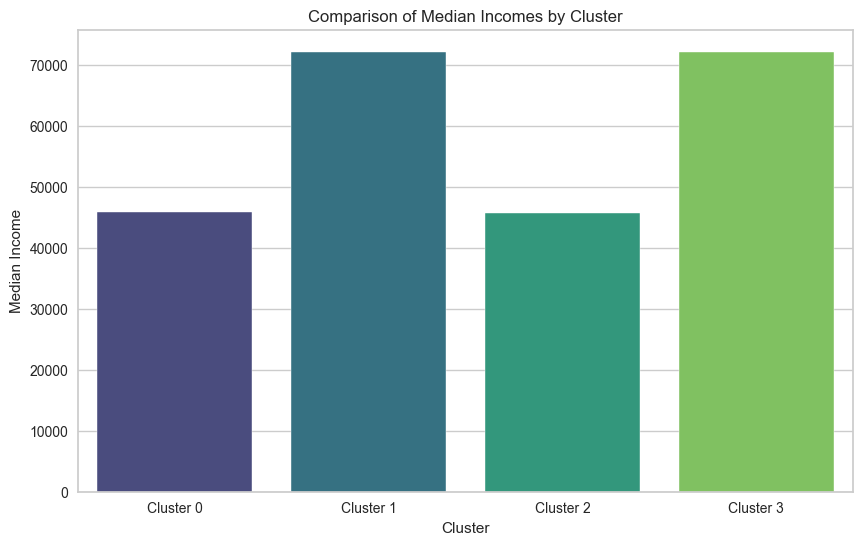

In [63]:
income_medians_df = pd.DataFrame(list(income_medians.items()), columns=['Cluster', 'Median Income'])

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='Median Income', data=income_medians_df, palette='viridis', hue='Cluster', legend=False)
plt.title('Comparison of Median Incomes by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Median Income')
plt.show()

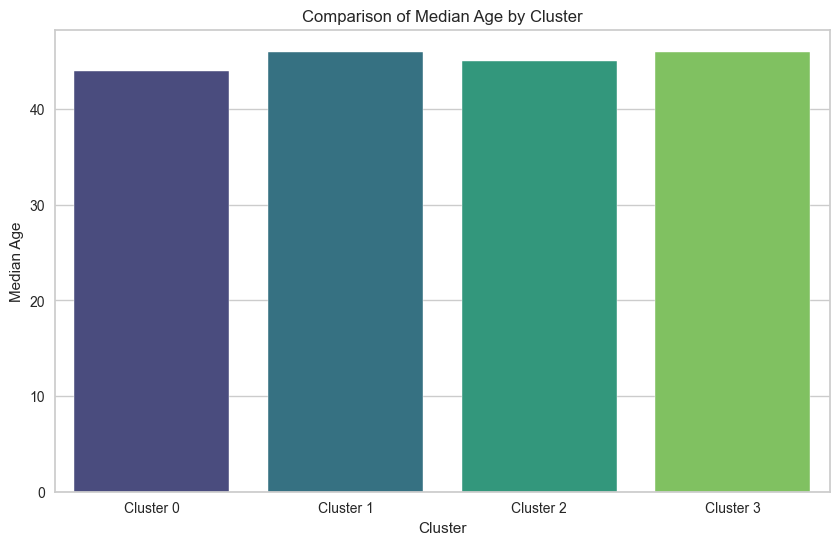

In [64]:
age_medians_df = pd.DataFrame(list(age_medians.items()), columns=['Cluster', 'Median Age'])

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='Median Age', data=age_medians_df, palette='viridis', hue='Cluster', legend=False)
plt.title('Comparison of Median Age by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Median Age')
plt.show()

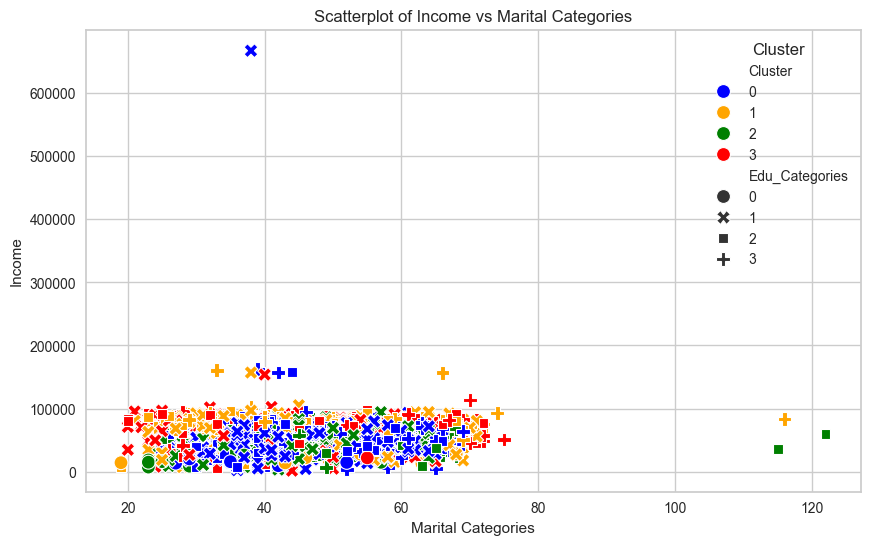

In [65]:
palette = {0: 'blue', 1: 'orange', 2: 'green', 3: 'red'}
# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Age', y='Income', hue='Cluster',  style='Edu_Categories', data=data, palette=palette, s=100)
plt.title('Scatterplot of Income vs Marital Categories')
plt.xlabel('Marital Categories')
plt.ylabel('Income')
plt.legend(title='Cluster')

plt.show()

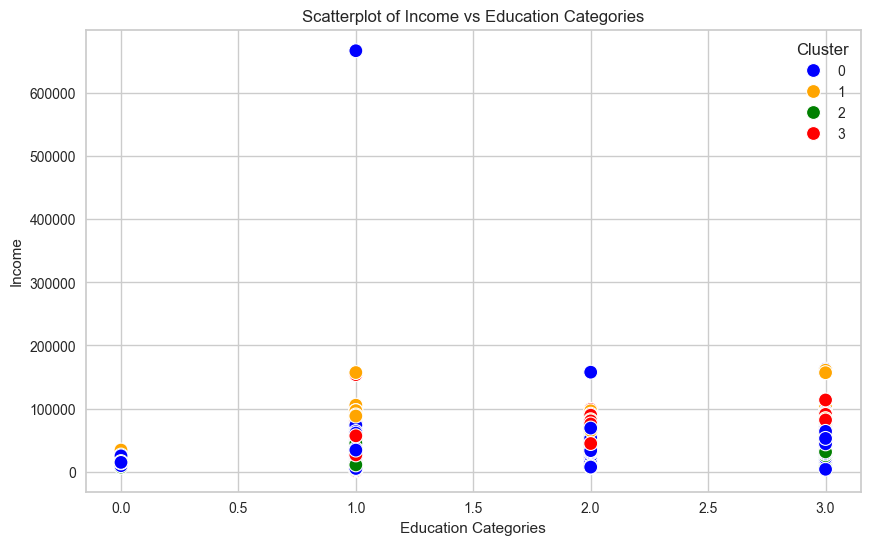

In [66]:
palette = {0: 'blue', 1: 'orange', 2: 'green', 3: 'red'}
# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Edu_Categories', y='Income', hue='Cluster', data=data, palette=palette, s=100)
plt.title('Scatterplot of Income vs Education Categories')
plt.xlabel('Education Categories')
plt.ylabel('Income')
plt.legend(title='Cluster')

plt.show()

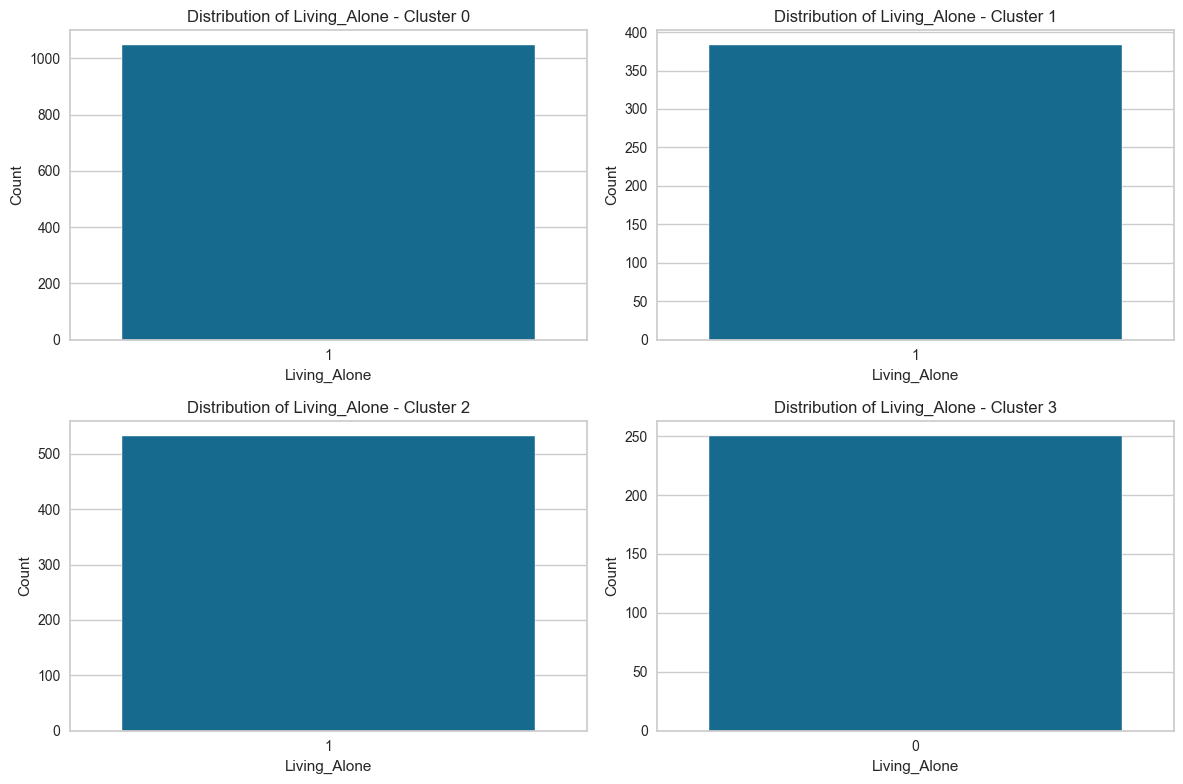

In [47]:
# Plotting
plt.figure(figsize=(12, 8))

# Iterate through each dataframe
for i, df in enumerate([cluster_0_df, cluster_1_df, cluster_2_df, cluster_3_df]):
    plt.subplot(2, 2, i + 1)  # Create subplot for each dataframe
    sns.countplot(x='Living_Alone', data=df)
    plt.title(f'Distribution of Living_Alone - Cluster {i}')
    plt.xlabel('Living_Alone')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()


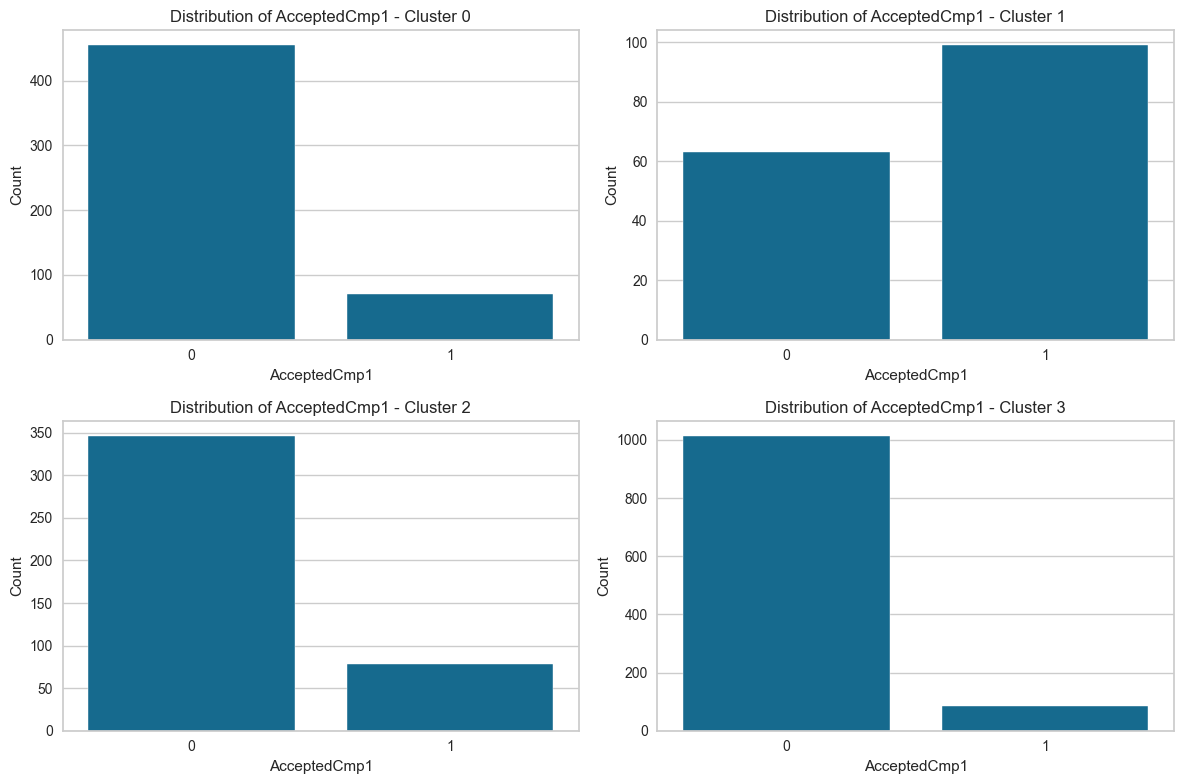

In [257]:
# Plotting
plt.figure(figsize=(12, 8))

# Iterate through each dataframe
for i, df in enumerate([cluster_0_df, cluster_1_df, cluster_2_df, cluster_3_df]):
    plt.subplot(2, 2, i + 1)  # Create subplot for each dataframe
    sns.countplot(x='Response', data=df)
    plt.title(f'Distribution of AcceptedCmp1 - Cluster {i}')
    plt.xlabel('AcceptedCmp1')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()